In [4]:
# Load ResNet pretrained on ImageNet

import torch
import torchvision
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import time

from load_data import BiopsyDataset, get_balanced_dataloader, BASIC_TRANSFORM, TEST_TRANSFORM, P53_CLASS_NAMES
from eval import get_accuracy_per_class

DATA_DIR = "../../data/biopsies_s1.0_anon_data/"

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device: {}".format(device))

Device: cuda


In [6]:
biopsies_dataset = BiopsyDataset(root_dir=DATA_DIR, class_names=P53_CLASS_NAMES,
    size=256, labels_filename="test", transform=BASIC_TRANSFORM)
print(f"Dataset size: {len(biopsies_dataset)}")

Class distribution:  {'Wildtype': 15, 'Overexpression': 15, 'Nullmutation': 15, 'Doubleclone': 15}


100%|██████████| 60/60 [00:12<00:00,  4.97it/s]

Dataset size: 60


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

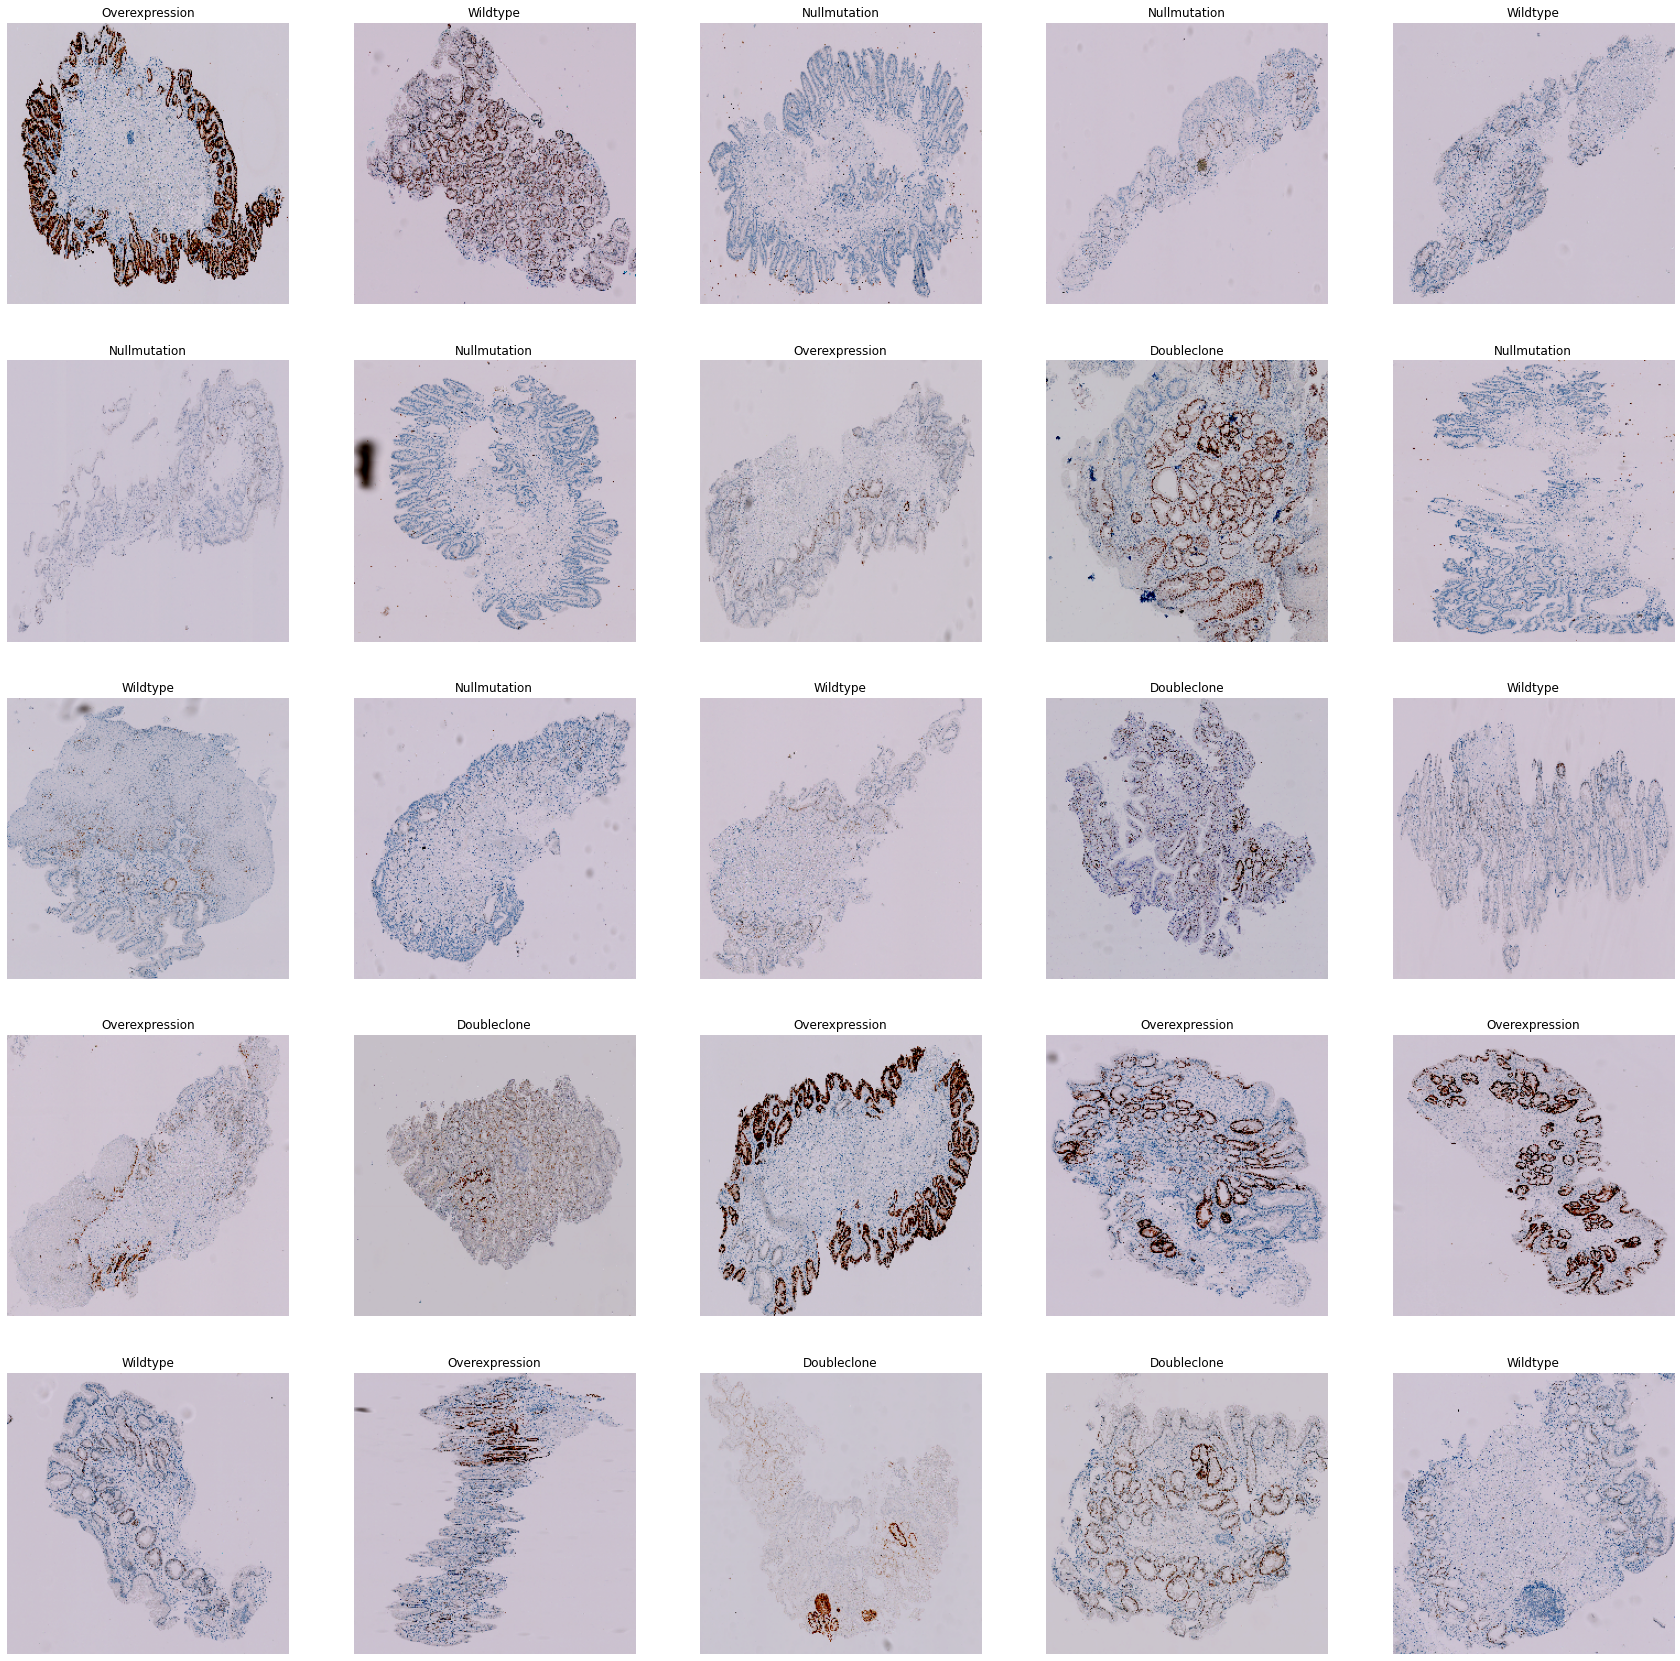

In [7]:
biopsies_dataset.plot_example_grid(figsize=(30,30))

Num classes:  4
Class names:  ['Wildtype', 'Overexpression', 'Nullmutation', 'Doubleclone']


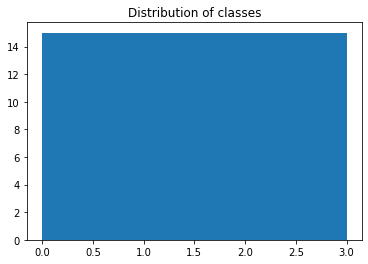

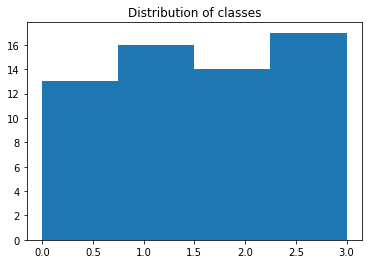

In [8]:
# Create the dataloaders
biopsies_dataloader = get_balanced_dataloader(biopsies_dataset, batch_size=32, weights_factor=None)
print("Num classes: ", biopsies_dataloader.dataset.num_classes)
print("Class names: ", biopsies_dataloader.dataset.class_names)

# Show actual distribution of classes
labels = []
for _, label in biopsies_dataset:
    labels.append(label)
labels = np.array(labels)
plt.hist(labels, bins=biopsies_dataset.num_classes)
plt.title("Distribution of classes")
plt.show()

# Show distribution of classes in dataloader
labels = []
for _, label in biopsies_dataloader:
    labels.append(label)
labels = torch.cat(labels)
labels = labels.numpy()
plt.hist(labels, bins=biopsies_dataset.num_classes)
plt.title("Distribution of classes")
plt.show()

# Train

In [9]:
# Hyper-parameters
batch_size = 32
learning_rate = 1e-5

# Load the datasets
train_dataset = BiopsyDataset(root_dir=DATA_DIR, class_names=P53_CLASS_NAMES,
    size=256, labels_filename="train", transform=BASIC_TRANSFORM)
test_dataset = BiopsyDataset(root_dir=DATA_DIR, class_names=P53_CLASS_NAMES,
    size=256, labels_filename="test", transform=TEST_TRANSFORM)

# Data loader using sampler for class balance
weights_factor = None
weights_factor = np.array([1.0, 1.0, 1.0, 0.0])
train_loader = get_balanced_dataloader(train_dataset, batch_size=batch_size, weights_factor=weights_factor)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


Class distribution:  {'Wildtype': 1125, 'Overexpression': 251, 'Nullmutation': 96, 'Doubleclone': 0}


  0%|          | 0/1472 [00:00<?, ?it/s]

100%|██████████| 1472/1472 [04:40<00:00,  5.24it/s]


Class distribution:  {'Wildtype': 15, 'Overexpression': 15, 'Nullmutation': 15, 'Doubleclone': 15}


100%|██████████| 60/60 [00:12<00:00,  4.70it/s]


ZeroDivisionError: float division by zero

# Normal Cross Entropy Loss

In [15]:
# Load ResNet18
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, train_dataset.num_classes)
model = model.to(device)

In [16]:
num_epochs = 100

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
total_step = len(train_loader)
start_time = time.time()
for epoch in range(num_epochs):
    model.train()

    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device).long()  # Convert labels to Long data type

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 50 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

    # Test the model
    model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)

    # Test accuracy per class
    with torch.no_grad():
        accuracy_per_class, _ = get_accuracy_per_class(model, test_loader, device)
        print(f"Accuracy per class: {accuracy_per_class}")
        print(f"Average accuracy: {np.mean(accuracy_per_class)}")
        print(f"Time elapsed: {time.time()-start_time} seconds")

    # Save the model checkpoint
    torch.save(model.state_dict(), 'resnet.ckpt')

Accuracy per class: [0.06666667 1.         0.46666667 0.        ]
Average accuracy: 0.3833333333333333
Time elapsed: 15.663882493972778 seconds
Accuracy per class: [0.86666667 0.8        0.66666667 0.        ]
Average accuracy: 0.5833333333333334
Time elapsed: 27.432472944259644 seconds
Accuracy per class: [0.86666667 0.66666667 0.53333333 0.        ]
Average accuracy: 0.5166666666666666
Time elapsed: 41.31754946708679 seconds


# Separate Binary Classification Loss

In [ ]:
def convert_status_to_presence(labels):
    """
    Convert labels, which are 0: wildtype, 1: overexpression, 2: nullmutation, 3: doubleclone
    to an array of size 2, where the first element is 1 if overexpression is present, and the second element is 1 if nullmutation is present.
    Wildtype is [0, 0], overexpression is [1, 0], nullmutation is [0, 1], doubleclone is [1, 1].
    """
    return torch.stack([(labels == 1) | (labels == 3), (labels == 2) | (labels == 3)], dim=1).float()

def convert_presence_to_status(presence):
    """
    Convert presence, which is an array of size 2, where the first element is 1 if overexpression is present, and the second element is 1 if nullmutation is present,
    to pred labels, where 0: wildtype, 1: overexpression, 2: nullmutation, 3: doubleclone.
    """
    labels = torch.zeros(presence.size(0), dtype=torch.float, device=presence.device) # Labels per sample

    # Get the presence prediction
    presence = presence > 0.5

    # Calculate the status
    labels += presence[:, 0] * 1
    labels += presence[:, 1] * 2
    return labels

In [ ]:
# Load ResNet18
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2) # One output for presence of overexpression, one for nullmutation (wildtype is when both are 0, doubleclone is when both are 1)
# Add sigmoid to the output
model.fc = nn.Sequential(model.fc, nn.Sigmoid())
model = model.to(device)

In [ ]:
num_epochs = 10

# Loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
total_step = len(train_loader)
print("Num batches: ", total_step)
start_time = time.time()
for epoch in range(num_epochs):
    model.train()

    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device).long()  # Convert labels to Long data type

        labels = convert_status_to_presence(labels)

        # Skew towards positive predictions
        labels = labels + 0.25

        # Forward pass
        outputs = model(images)

        # Treat as double binary classification problem instead of multiclass classification problem
        loss1 = criterion(outputs[:, 0], labels[:, 0])
        loss2 = criterion(outputs[:, 1], labels[:, 1])
        loss = loss1 + loss2

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 50 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

    # Test the model
    model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)

    # Test accuracy per class
    with torch.no_grad():
        accuracy_per_class, _ = get_accuracy_per_class(model, test_loader, device, convert_presence_to_status)
        print(f"Accuracy per class: {accuracy_per_class}")
        print(f"Average accuracy: {np.mean(accuracy_per_class)}")
        print(f"Time elapsed: {time.time()-start_time} seconds")

    # Save the model checkpoint
    torch.save(model.state_dict(), 'resnet_bce.ckpt')

# Visualize

array([[14.,  0.,  1.,  0.],
       [ 1., 14.,  0.,  0.],
       [ 7.,  0.,  8.,  0.],
       [ 3., 11.,  1.,  0.]])

Accuracy per class: [0.93333333 0.93333333 0.53333333 0.        ]
Average accuracy: 0.6


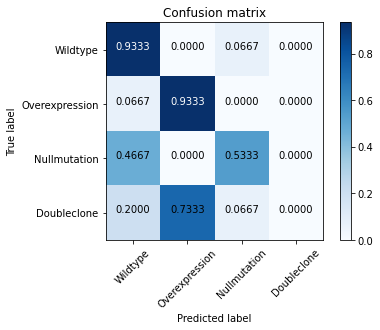

In [8]:
from eval import plot_confusion_matrix

# Load the model checkpoint
# model.load_state_dict(torch.load('resnet.ckpt'))

# Test the model
model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)

with torch.no_grad():
    accuracy_per_class, confusion_matrix = get_accuracy_per_class(model, test_loader, device, 
        # convert_presence_to_status
        )
    display(confusion_matrix)
    print(f"Accuracy per class: {accuracy_per_class}")
    print(f"Average accuracy: {np.mean(accuracy_per_class)}")

    # Plot the confusion matrix
    plot_confusion_matrix(confusion_matrix, ["Wildtype", "Overexpression", "Nullmutation", "Doubleclone"])